## 0. Importing Required Packages

In [910]:
# Start with loading all necessary libraries
#Importing general purpose python libraries below
import pandas as pd
import numpy as np
import sklearn
import warnings
warnings.filterwarnings("ignore")
import datetime
#tqdm is great for measure progress on long-running tasks
from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import tqdm
tqdm.pandas()
import pickle

#For charts and visualizations
import matplotlib.pyplot as plt
#% matplotlib inline
import seaborn as sns

#For Wordclouds
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#For NLP & Feature Extraction
from textatistic import Textatistic
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

#For modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score

# Import the classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [1062]:
# Importing Quora Question Pairs Datasets
train = pd.read_csv('quora-question-pairs/train.csv').fillna("empty")

## 1. Understanding the Data (EDA)

In [792]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


* Our end goal is to classify a pair of questions as duplicate or not. 
* Given that the dataset only has two features -  question1 and question 2 - we will have to use NLP and extract our own features in order to train the model.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404290 non-null  object
 4   question2     404290 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


There are 149,263 duplicates
Which is 36.92% of the training set


<AxesSubplot:xlabel='is_duplicate'>

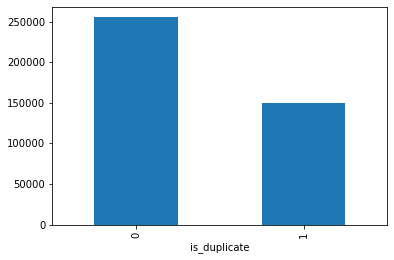

In [6]:
#What is the proportion of each class in the training data?
print(f'There are {train.groupby("is_duplicate")["id"].count()[1]:,} duplicates')

print(f'Which is {np.sum(train["is_duplicate"]==1)*100/train.shape[0]:.2f}% of the training set')

train.groupby("is_duplicate")['id'].count().plot.bar()

In [7]:
# How many unique questions in this dataset?
set1 = set(train['question1'])
set2 = set(train['question2'])
set_total = set1 | set2

print(f"Question 1s : {len(train['question1']):,}")
print(f"Unique question 1s : {len(set1):,} \n")

print(f"Question 2s : {len(train['question2']):,}")
print(f"Unique question 2s : {len(set2):,}\n")

print(f"Total questions : {len(train['question1'])+len(train['question2']):,}")
print(f"Total Unique questions : {len(set_total):,}")

Question 1s : 404,290
Unique question 1s : 290,457 

Question 2s : 404,290
Unique question 2s : 299,175

Total questions : 808,580
Total Unique questions : 537,361


In [8]:
#Are there any cases where question 1 = question 2?
train[train['question1']==train['question2']]

,id,qid1,qid2,question1,question2,is_duplicate


## Key Takeaways:
* Model Features 
    * Given that the dataset only has two features -  question1 and question 2 - we will have to use NLP and extract our own features in order to train the model.
* Class Imbalance
    * The dataset is slightly imbalanced (37% duplicates), so we will have to factor this into our model evaluation metrics or rectify this when sampling. Here's a good reference article on how to deal with Class Imbalance: https://towardsdatascience.com/how-to-effectively-predict-imbalanced-classes-in-python-e8cd3b5720c4

### What types of questions are in the dataset?

There are 49,179,901 words in the combination of all questions.


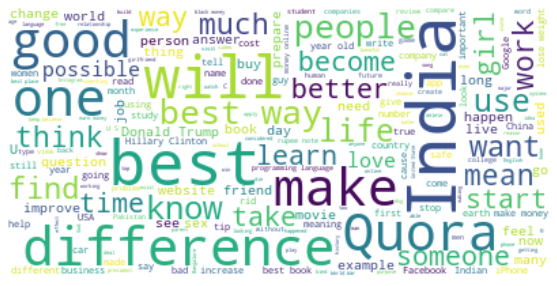

In [9]:
#Creating a WordCloud to understand what users are asking at a glance
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)

#Create a WordCloud for all questions
text = " ".join(train_qs.astype(str))
print (f"There are {len(text):,} words in the combination of all questions.")

# Create stopword list:
#stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white", max_font_size=50, max_words=1000).generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=[12,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [793]:
# View sample questions
pd.set_option('display.max_colwidth', 0)
train[['question1','question2','is_duplicate']].sample(n=10, random_state=42)

,question1,question2,is_duplicate
8067,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
368101,What are some of the best side dishes for crab cakes?,What are some good side dishes for buffalo chicken?,0
70497,"Which is more advisable and better material for a crash test in automobiles, ductile or brittle?",What is the best server setup for buddypress?,0
226567,How do I improve logical programming skills?,How can I improve my logical skills for programming?,1
73186,How close we are to see 3rd world war?,How close is a World War III?,1
215105,What do Chinese people think about Donald Trump?,What do Chinese people think of Donald Trump?,1
253209,How many hours a week do Google employees work?,How many hours a day do Google employees work on average?,0
354651,How can we follow a Quora question privately without the knowledge of others users?,How can we view private Instagram pictures without following them?,0
104478,Why are cats so overprotective?,How do you know if your cat is overprotective?,1
163628,How do I improve logical programming skills?,What is the best way to improve logical skills in programming?,1


In [11]:
# Understanding the corpus further: What are the different punctuation characters?
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print(f'Questions with question marks: {qmarks * 100:.2f}%')
print(f'Questions with [math] tags: {math * 100:.2f}%')
print(f'Questions with full stops: {fullstop * 100:.2f}%')
print(f'Questions with capitalised first letters: {capital_first * 100:.2f}%')
print(f'Questions with capital letters: {capitals * 100:.2f}%')
print(f'Questions with numbers: {numbers * 100:.2f}%')

Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%


In [12]:
# View a sample of questions and class values
samples = [train[train['is_duplicate']==1].sample(50000,random_state=42),
               train[train['is_duplicate']!=1].sample(50000,random_state=42)]
df = pd.concat(samples,ignore_index=True)
df.sample(10,random_state=2)

,id,qid1,qid2,question1,question2,is_duplicate
6448,379754,511294,511295,How do I study chemistry?,How do I study of chemistry?,1
50680,244762,357452,333717,Does Trump and his supporters believe that cooperations are for dummies?,What does it feel like to be a Trump supporter after his win?,0
814,38119,69277,16524,Is it real that new currency note in India will have GPS chips?,Is it true that the new 2000 rupees notes have a GPS chips?,1
20354,117586,191303,191304,"How could ""Albert Abraham Michelson"" and ""Edward Morley"" have proceeded, having known the invariance of the speed of light C?","How could ""Albert Abraham Michelson"" and ""Edward Morley"" have proceeded, having known the invariance of the velocity of light C?",1
49224,80323,136572,136573,How can I become more cultured and charismatic?,Can charisma really make a person seem more attractive than he/she really is? How can I become more charismatic?,1
96712,202799,305202,305203,What's the best webinar software?,What is the best software for conducting webinars?,0
76353,2759,5475,5476,"Which one is better: Quora, Stack Exchange or Reddit?","How do I stop thinking about Quora, SMS, Stack Exchange, etc. when I am in bed?",0
91607,221568,328942,328943,I got 9.0 cgpa in 10th cbse and a measly 65% in 12th class 88% in BTECH CSE.How much score do i have to get in GRE so as to get into a good MS program,I got a 9.2 CGPA in 10th. I got 78.4 in 12th. What should I do for getting into an NYC college?,0
65153,297967,21317,5028,How do I recover/reset my AOL email password?,How to reset password for gmail via sms?,0
13542,244341,356958,121836,Why do watermelon have seeds?,Why do watermelons have so many seeds?,1


In [13]:
df.describe()

,id,qid1,qid2,is_duplicate
count,100000.00000,100000.000000,100000.000000,100000.000000
mean,201993.48857,206761.110100,209673.002570,0.500000
std,116329.09707,156969.323452,158918.739988,0.500003
min,4.00000,9.000000,10.000000,0.000000
25%,101305.75000,64893.250000,65235.000000,0.000000
50%,201897.00000,176664.000000,179843.500000,0.500000
75%,302552.00000,331924.500000,338805.250000,1.000000
max,404287.00000,537928.000000,537929.000000,1.000000


## 2. Creating initial variables for model
- Length of questions
- Difference in length between q1 and q2
- Number of words in each question
- Normalized Word Share (how many words are in both questions)
- Difference between Readability Scores
    A good resource on Readability Scores:
    https://www.kaggle.com/fshenbayh/readability
    https://www.geeksforgeeks.org/readability-index-pythonnlp/

In [85]:
#Textastistic Readability Scores
df['question1'][2]
Textatistic(df['question1'][2]).scores

{'flesch_score': 55.952500000000015,
 'fleschkincaid_score': 7.442500000000003,
 'gunningfog_score': 8.200000000000001,
 'smog_score': 8.841846274778883,
 'dalechall_score': 7.9807999999999995}

In [27]:
# Creating q1 length, q2 length and difference in length
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()
df['qlen_diff']= abs(df['q1len'] - df['q2len'])

# Creating number of words features, and difference in number of words
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
df['q_n_words_diff'] = abs(df['q1_n_words'] - df['q2_n_words'])

# How many words do the questions have in common?
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].replace('?','').split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].replace('?','').split(" ")))    
    return 2.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

# Extracting Flesch readability score
def read_diff_flesch(x):
    try: return Textatistic(x).scores['flesch_score']
    except: return 0
    
# Extracting Dale Chall readability score
def read_diff_dalechall(x):
    try: return Textatistic(x).scores['dalechall_score']
    except: return 0

df['flesch_diff'] = abs(df['question1'].progress_apply(lambda x: read_diff_flesch(x)) - df['question2'].progress_apply(lambda x: read_diff_flesch(x)))
df['dalechall_diff'] = abs(df['question1'].progress_apply(lambda x: read_diff_dalechall(x)) - df['question2'].progress_apply(lambda x: read_diff_dalechall(x)))

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share,flesch_diff,dalechall_diff,q_n_words_diff,qlen_diff
0,95846,159763,159764,Should I sell an iPhone 6s and buy an iPhone SE?,Should I buy the iPhone 6s or an SE?,1,48,36,11,9,0.777778,2.030000,0.577685,2,12
1,71793,98077,47801,What happened to the famous people who believed and confirmed the world would end in 2012 and what do they say why it didn't happen?,What happened to people who sold off all their belongings in 2012 in preparation for the end of the world?,1,132,106,25,20,0.500000,0.001000,0.563800,5,26
2,51542,21553,27734,What are some of the top paying career options after doing a B.Tech in mechanical engineering?,What is the best field for earning money after completing a B.Tech in mechanical engineering?,1,94,93,16,15,0.516129,2.270000,0.814300,1,1
3,212804,317964,317965,How can I use my time productively during slow day at work?,What can I do on a boring day at work?,1,59,38,12,10,0.454545,14.720000,0.163967,2,21
4,373008,503769,503770,What is the revenue model for blogging?,What could be the revenue model for a blogging company?,1,39,55,7,10,0.705882,4.253571,1.881343,3,16


In [28]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate', 'q1len',
       'q2len', 'q1_n_words', 'q2_n_words', 'word_share', 'flesch_diff',
       'dalechall_diff', 'q_n_words_diff', 'qlen_diff'],
      dtype='object')

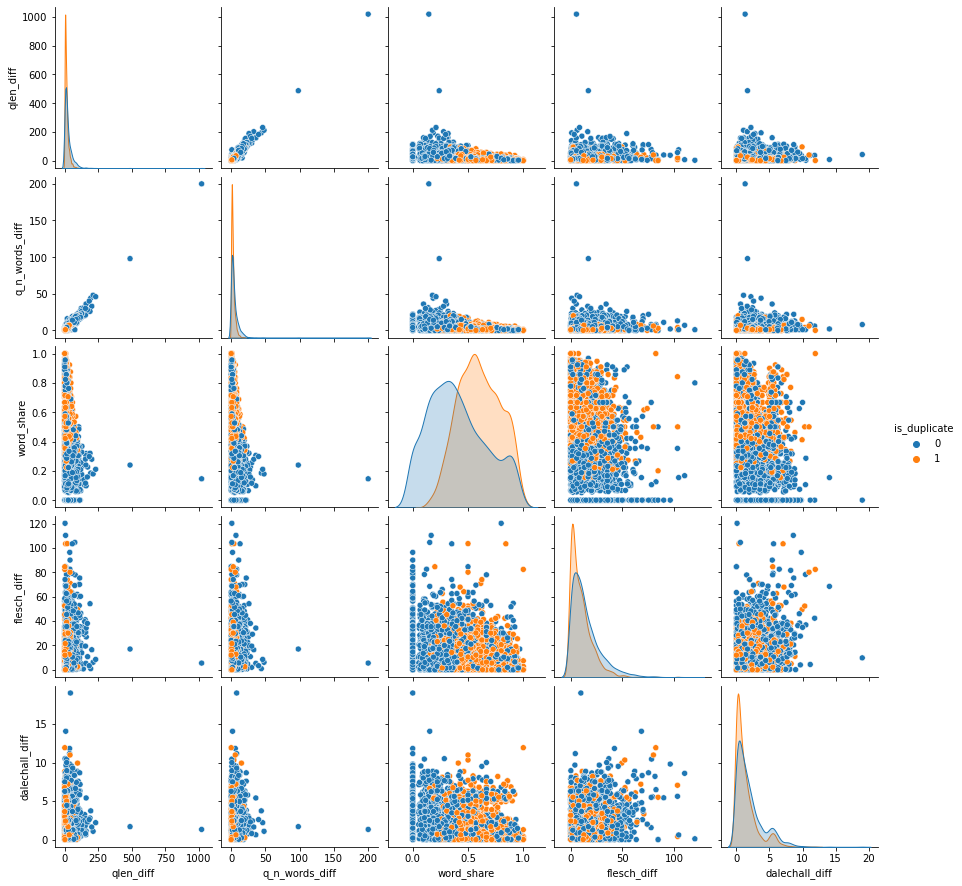

In [78]:
# View pairplots to understand correlations and difference between class distributions by variable
features = [ 'qlen_diff','q_n_words_diff','word_share', 'flesch_diff', 'dalechall_diff','is_duplicate']
sns.pairplot(df[features].sample(5000), hue='is_duplicate')

## Initial Logistic Regression Model
* AUC = 0.73
* Precision = 0.66
* Recall = 0.69
* Accuracy = 0.67

In [832]:
# Input variables
features = ['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share', 'flesch_diff','dalechall_diff', 'q_n_words_diff', 'qlen_diff']

# Scale using MinMaxScaler to ensure that range of one variable doesn't dominate the model
scaler = MinMaxScaler().fit(df[features])
X = scaler.transform(df[features])
y = df['is_duplicate']

# Split into 70:30 train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70000, 9), (30000, 9), (70000,), (30000,))

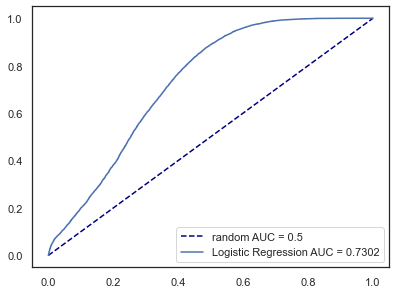

In [841]:
# Build a simple logistic regression classifier to serve as a baseline model
clf = LogisticRegression()
clf.fit(X_train, y_train)
plt.figure(figsize = [6.4, 4.8])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr)
label=['random AUC = 0.5']
label.append(f"Logistic Regression AUC = {np.round(roc_auc, 4)}")
plt.legend(label)

In [100]:
# View test vs train precision, recall and accuracy
y_pred=clf.predict(X_test)
y_pred_train=clf.predict(X_train)
print(f"Test Precision: {sklearn.metrics.precision_score(y_test, y_pred):.4f}")
print(f"Train Precision: {sklearn.metrics.precision_score(y_train, y_pred_train):.4f}")
print(f"Test Recall: {sklearn.metrics.recall_score(y_test, y_pred):.4f}")
print(f"Train Recall: {sklearn.metrics.recall_score(y_train, y_pred_train):.4f}")
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred):.4f}")
print(f"Train Accuracy: {metrics.accuracy_score(y_train, y_pred_train):.4f}")

Test Precision: 0.6623
Train Precision: 0.6629
Test Recall: 0.6901
Train Recall: 0.6888
Test Accuracy: 0.6679
Train Accuracy: 0.6698


## 3. Extracting Additional Features

* Tokenization & Lemmatization
* Removing Stop Words
* Tf-Idf Vectorization
    * Cosine Similarity
    * Tf-Idf Word Share Score
* Named Entity Recognition
    * Difference in Number of Entities
    * Common Entity Count
    * Common Entity Types

In [149]:
# Load Spacy's 'en_core_web_lg' model and stop words
nlp = spacy.load('en_core_web_lg')
from spacy.lang.en.stop_words import STOP_WORDS

In [162]:
#Tokenization and Lemmatization
def preprocess(text):
    # Create Doc object
    doc = nlp(text.lower(), disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in STOP_WORDS]
    return ' '.join(a_lemmas)
  
# Apply preprocess to df_small
df['q1_cleaned'] = df['question1'].progress_apply(preprocess)
df['q2_cleaned'] = df['question2'].progress_apply(preprocess)

In [164]:
# View newly created variables
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share,flesch_diff,dalechall_diff,q_n_words_diff,qlen_diff,q1_cleaned,q2_cleaned
0,95846,159763,159764,Should I sell an iPhone 6s and buy an iPhone SE?,Should I buy the iPhone 6s or an SE?,1,48,36,11,9,0.777778,2.030000,0.577685,2,12,sell iphone buy iphone se,buy iphone se
1,71793,98077,47801,What happened to the famous people who believed and confirmed the world would end in 2012 and what do they say why it didn't happen?,What happened to people who sold off all their belongings in 2012 in preparation for the end of the world?,1,132,106,25,20,0.500000,0.001000,0.563800,5,26,happen famous people believe confirm world end happen,happen people sell belonging preparation end world
2,51542,21553,27734,What are some of the top paying career options after doing a B.Tech in mechanical engineering?,What is the best field for earning money after completing a B.Tech in mechanical engineering?,1,94,93,16,15,0.516129,2.270000,0.814300,1,1,pay career option mechanical engineering,good field earn money complete mechanical engineering
3,212804,317964,317965,How can I use my time productively during slow day at work?,What can I do on a boring day at work?,1,59,38,12,10,0.454545,14.720000,0.163967,2,21,use time productively slow day work,boring day work
4,373008,503769,503770,What is the revenue model for blogging?,What could be the revenue model for a blogging company?,1,39,55,7,10,0.705882,4.253571,1.881343,3,16,revenue model blogging,revenue model blogging company


## TF-IDF Vectorization: Cosine Similarity & Word Share Score

In [499]:
#define corpus
corpus = df["q1_cleaned"].to_list() + df["q2_cleaned"].to_list()

# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer(max_features = 2000, stop_words = "english")

# fit the vectorizer using the text data
tfidf_wm = tfid_vectorizer.fit_transform(corpus)

In [318]:
# Calculate cosine similarity array between question pairs
tfidf_cosine_sim = []
counter=0
a1 = np.array(tfidf_wm.todense()[:100000])
b1 = np.array(tfidf_wm.todense()[100000:200000])
for i in range(a1.shape[0]):
    tfidf_cosine_sim.append(float(np.dot(a1[i],b1[i].T)))
    counter+=1
    if counter%10000 == 0:
        print(counter,' rows complete')
df['tfidf_cosine_sim_'] = tfidf_cosine_sim

10000  rows complete
20000  rows complete
30000  rows complete
40000  rows complete
50000  rows complete
60000  rows complete
70000  rows complete
80000  rows complete
90000  rows complete
100000  rows complete


In [319]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,...,q2_cleaned,tfidf_cosine_sim,entities1,entity_types1,entities2,entity_types2,diff_num_entities,common_entities,common_entity_types,tfidf_cosine_sim_
0,95846,159763,159764,Should I sell an iPhone 6s and buy an iPhone SE?,Should I buy the iPhone 6s or an SE?,1,48,36,11,9,...,buy iphone se,0.852049,"[iPhone, 6s, iPhone SE]","[ORG, PRODUCT, ORG]","[iPhone, 6s]","[ORG, PRODUCT]",1,2,2,0.847623
1,71793,98077,47801,What happened to the famous people who believed and confirmed the world would end in 2012 and what do they say why it didn't happen?,What happened to people who sold off all their belongings in 2012 in preparation for the end of the world?,1,132,106,25,20,...,happen people sell belonging preparation end world,0.579798,[2012],[DATE],[2012],[DATE],0,1,1,0.576517
2,51542,21553,27734,What are some of the top paying career options after doing a B.Tech in mechanical engineering?,What is the best field for earning money after completing a B.Tech in mechanical engineering?,1,94,93,16,15,...,good field earn money complete mechanical engineering,0.340077,[],[],[],[],0,0,0,0.343914
3,212804,317964,317965,How can I use my time productively during slow day at work?,What can I do on a boring day at work?,1,59,38,12,10,...,boring day work,0.578367,[],[],[a boring day],[DATE],1,0,0,0.576799
4,373008,503769,503770,What is the revenue model for blogging?,What could be the revenue model for a blogging company?,1,39,55,7,10,...,revenue model blogging company,0.896425,[],[],[],[],0,0,0,0.894581


In [363]:
# Extract vectorizer keywords
tfidf_tokens = tfid_vectorizer.get_feature_names()

In [425]:
#Calculate word match and weight it using tf-idf scores
tfidf_word_match=[]
for ix in range(df.shape[0]):
    q1words = {}
    q2words = {}
    for word in str(df.iloc[ix]['q1_cleaned']).lower().split():
        if word not in STOP_WORDS:
            q1words[word] = 1
    for word in str(df.iloc[ix]['q2_cleaned']).lower().split():
        if word not in STOP_WORDS:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        tfidf_word_match.append(0)
    else:
        shared_weights = [q1weights[ix][w] for w in q1words.keys() if w in q1weights[ix].keys() if w in q2words] + [q2weights[ix][w] for w in q2words.keys() if w in q2weights[ix].keys() if w in q1words]
        total_weights = [q1weights[ix][w] for w in q1words if w in q1weights[ix].keys()] + [q2weights[ix][w] for w in q2words if w in q2weights[ix].keys()]
        R = np.sum(shared_weights) / np.sum(total_weights)
        tfidf_word_match.append(R)
    if ix%10000==0:
        print(ix)
# Save array in dataframe        
df['tfidf_word_match']=tfidf_word_match
df['tfidf_word_match']=df['tfidf_word_match'].fillna(0)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [454]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,...,tfidf_cosine_sim,entities1,entity_types1,entities2,entity_types2,diff_num_entities,common_entities,common_entity_types,tfidf_cosine_sim_,tfidf_word_match
0,95846,159763,159764,Should I sell an iPhone 6s and buy an iPhone SE?,Should I buy the iPhone 6s or an SE?,1,48,36,11,9,...,0.852049,"[iPhone, 6s, iPhone SE]","[ORG, PRODUCT, ORG]","[iPhone, 6s]","[ORG, PRODUCT]",1,0.8,0.8,0.847623,0.850505
1,71793,98077,47801,What happened to the famous people who believed and confirmed the world would end in 2012 and what do they say why it didn't happen?,What happened to people who sold off all their belongings in 2012 in preparation for the end of the world?,1,132,106,25,20,...,0.579798,[2012],[DATE],[2012],[DATE],0,1.0,1.0,0.576517,0.632866
2,51542,21553,27734,What are some of the top paying career options after doing a B.Tech in mechanical engineering?,What is the best field for earning money after completing a B.Tech in mechanical engineering?,1,94,93,16,15,...,0.340077,[],[],[],[],0,-1.0,-1.0,0.343914,0.344396
3,212804,317964,317965,How can I use my time productively during slow day at work?,What can I do on a boring day at work?,1,59,38,12,10,...,0.578367,[],[],[a boring day],[DATE],1,0.0,0.0,0.576799,0.619844
4,373008,503769,503770,What is the revenue model for blogging?,What could be the revenue model for a blogging company?,1,39,55,7,10,...,0.896425,[],[],[],[],0,-1.0,-1.0,0.894581,0.856597


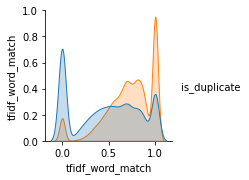

In [444]:
# View distribution of tfidf word match by class labels
sns.pairplot(df[['tfidf_word_match','is_duplicate']], hue='is_duplicate')

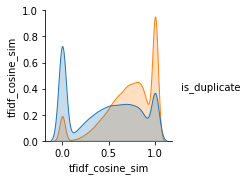

In [333]:
# View distribution of tfidf cosine similarity by class labels
sns.pairplot(df[['tfidf_cosine_sim','is_duplicate']], hue='is_duplicate')

## Named Entity Recognition

In [260]:
def preprocess_entities(text):
    doc = nlp(text, disable = ['parser'])
    return [X.text for X in doc.ents], [X.label_ for X in doc.ents]

In [262]:
#Extract Entities for each question
df['entities1'], df['entity_types1'] = zip(*df['question1'].progress_map(preprocess_entities))
df['entities2'], df['entity_types2'] = zip(*df['question2'].progress_map(preprocess_entities))

In [348]:
#Compare entities between questions
df['diff_num_entities'] = df.progress_apply(lambda x: abs(len(x['entities1']) - len(x['entities2'])), axis = 1)
df['common_entities'] = df.progress_apply(lambda x: -1 if len(x['entities1'])+len(x['entities2']) == 0 else 2*len(set(x['entities1']).intersection(set(x['entities2'])))/(len(x['entities1'])+len(x['entities2'])), axis=1)
df['common_entity_types'] = df.progress_apply(lambda x: -1 if len(x['entity_types1'])+len(x['entity_types2']) == 0 else 2*len(set(x['entity_types1']).intersection(set(x['entity_types2'])))/(len(x['entity_types1'])+len(x['entity_types2'])), axis=1)

In [349]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,...,q2_cleaned,tfidf_cosine_sim,entities1,entity_types1,entities2,entity_types2,diff_num_entities,common_entities,common_entity_types,tfidf_cosine_sim_
0,95846,159763,159764,Should I sell an iPhone 6s and buy an iPhone SE?,Should I buy the iPhone 6s or an SE?,1,48,36,11,9,...,buy iphone se,0.852049,"[iPhone, 6s, iPhone SE]","[ORG, PRODUCT, ORG]","[iPhone, 6s]","[ORG, PRODUCT]",1,0.8,0.8,0.847623
1,71793,98077,47801,What happened to the famous people who believed and confirmed the world would end in 2012 and what do they say why it didn't happen?,What happened to people who sold off all their belongings in 2012 in preparation for the end of the world?,1,132,106,25,20,...,happen people sell belonging preparation end world,0.579798,[2012],[DATE],[2012],[DATE],0,1.0,1.0,0.576517
2,51542,21553,27734,What are some of the top paying career options after doing a B.Tech in mechanical engineering?,What is the best field for earning money after completing a B.Tech in mechanical engineering?,1,94,93,16,15,...,good field earn money complete mechanical engineering,0.340077,[],[],[],[],0,-1.0,-1.0,0.343914
3,212804,317964,317965,How can I use my time productively during slow day at work?,What can I do on a boring day at work?,1,59,38,12,10,...,boring day work,0.578367,[],[],[a boring day],[DATE],1,0.0,0.0,0.576799
4,373008,503769,503770,What is the revenue model for blogging?,What could be the revenue model for a blogging company?,1,39,55,7,10,...,revenue model blogging company,0.896425,[],[],[],[],0,-1.0,-1.0,0.894581


## BERT Similarity Scores

In [641]:
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [677]:
doc_embeddings1 = []
for i in tqdm(range(df.shape[0])):
    doc_embeddings1.append(sbert_model.encode(df['question1'][i]))
    if i%10000==0:
        print(i)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000



In [678]:
doc_embeddings2 = []
for i in tqdm(range(df.shape[0])):
    doc_embeddings2.append(sbert_model.encode(df['question2'][i]))
    if i%10000==0:
        print(i)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000



In [686]:
type(doc_embeddings1[0])

numpy.ndarray

In [687]:
bert_cosine_sim = []
counter=0
# a1 = np.array(tfidf_wm.todense()[:100000])
# b1 = np.array(tfidf_wm.todense()[100000:200000])
for i in tqdm(range(len(doc_embeddings1))):
    bert_cosine_sim.append(float(np.dot(doc_embeddings1[i],doc_embeddings2[i].T)/
                                 (np.linalg.norm(doc_embeddings1[i], ord=2)*
                                  np.linalg.norm(doc_embeddings2[i], ord=2))))
    counter+=1
    if counter%10000 == 0:
        print(counter,' rows complete')
df['bert_cosine_sim_'] = bert_cosine_sim

10000  rows complete
20000  rows complete
30000  rows complete
40000  rows complete
50000  rows complete
60000  rows complete
70000  rows complete
80000  rows complete
90000  rows complete
100000  rows complete



In [680]:
objects = [doc_embeddings1,doc_embeddings2,df]
object_names = ['doc_embeddings1','doc_embeddings2','df']
for ix, i in enumerate(objects):
    pickle.dump(i, open( "20210404_"+str(object_names[ix])+".p", "wb" ) )

In [695]:
df.nsmallest(5,'bert_cosine_sim_')

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,...,entities1,entity_types1,entities2,entity_types2,diff_num_entities,common_entities,common_entity_types,tfidf_cosine_sim_,tfidf_word_match,bert_cosine_sim_
56556,189396,288142,288143,Which,Which Fake GPS with Joystick app will work for Pokémon go in Redmi note 3(Lollipop)?,0,5,84,1,15,...,[],[],"[Joystick, Redmi note 3(Lollipop]","[ORG, ORG]",2,0.0,0.0,0.0,0.0,-0.081385
98713,383009,514920,514921,What types of links are considered good links?,A horse rider went a mile in 5 minutes with the wind and returned in 7 minutes against the wind. How fast could he ride a mile if there was no wind?,0,46,148,8,32,...,[],[],"[a mile, 5 minutes, 7 minutes]","[QUANTITY, TIME, TIME]",3,0.0,0.0,0.0,0.0,-0.080265
53648,356434,147899,485756,Deleted.,Do gay men find red headed men more attractive than women find red headed men?,0,8,78,1,15,...,[],[],[],[],0,-1.0,-1.0,0.0,0.0,-0.035901
83112,9076,17657,17658,"Why do joggers early in the morning and in the evening wear dark clothes and run in the streets without a flashlight, even when there are sidewalks?",If I accept a message can I then delete that I read it?,0,148,55,27,13,...,"[early in the morning, evening]","[TIME, TIME]",[],[],2,0.0,0.0,0.0,0.0,-0.028909
74282,31231,57595,57596,What is thermal energy and how can it be found?,"My cat which was just relaxing on my bed, got up, left my room, turned around and sat there staring at me for a minute. What is she thinking?",0,47,141,10,29,...,[],[],[a minute],[TIME],1,0.0,0.0,0.0,0.0,-0.027189


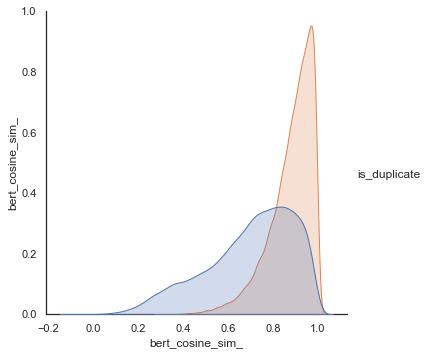

In [820]:
sns.set_style("white")
sns.pairplot(df[['bert_cosine_sim_','is_duplicate']], hue='is_duplicate', size=5)

## XGBoost

In [729]:
import sys
print(sys.base_prefix)

/opt/anaconda3


In [872]:
import xgboost as xgb

In [873]:
model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model.fit(X_train, y_train)
model.score(X_test,y_test)

[18:10:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7656333333333334

In [874]:
model.score(X_train, y_train)

0.7723285714285715

In [875]:
yproba = model.predict_proba(X_test)[::,1]
y_pred=model.predict(X_test)
y_pred_train=model.predict(X_train)

fpr, tpr, _ = roc_curve(y_test,  yproba)
auc = roc_auc_score(y_test, yproba)

In [876]:
auc

0.8452905444617645

In [749]:
df['model_pred'] = model.predict(X)
df['model_score'] = model.predict_proba(X)[::1]

In [763]:
df.loc[(df['is_duplicate']==0)&(df['model_pred']==1)]

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,...,entities2,entity_types2,diff_num_entities,common_entities,common_entity_types,tfidf_cosine_sim_,tfidf_word_match,bert_cosine_sim_,model_score,model_pred
50001,172363,80922,238253,How do I jailbreak iOS 9.3.4?,How do I jailbreak iOS 9.2.1?,0,29,29,6,6,...,[iOS 9.2.1],[LAW],0,0.000000,0.000000,1.000000,1.000000,0.959066,0.327992,1
50005,358749,412935,43796,Is it really possible to increase penis size and girth naturally?,Can the penis size (length or girth) be permanently increased?,0,65,62,11,10,...,[],[],0,-1.000000,-1.000000,0.543630,0.574091,0.941394,0.413815,1
50008,259783,375608,375609,What are requirements to become Indian para commando?,What is a comparison of the Indian army commando and the US commando?,0,53,69,8,13,...,"[Indian, US]","[NORP, GPE]",1,0.000000,0.000000,0.308002,0.400455,0.785280,0.480237,1
50017,231741,78770,341616,Will Mike Pence becomes president after the impeachment of Trump?,Could a bipartisan impeachment of Trump and Pence happen? Could it be likely?,0,65,77,10,13,...,[Trump],[ORG],1,0.666667,0.666667,0.320048,0.367268,0.806737,0.488807,1
50021,91359,153112,153113,What are the tastiest Indian vegetarian dish?,What is the tastiest Indian dish?,0,45,33,7,6,...,[Indian],[NORP],0,1.000000,1.000000,0.750585,0.785330,0.819097,0.434368,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99986,73391,125940,125941,What is the best networking certification?,Which is best networking class in Pune?,0,42,39,6,7,...,[Pune],[GPE],1,0.000000,0.000000,0.493854,0.511581,0.845476,0.394986,1
99987,258171,373651,373652,"If we can't divide a number by zero, then how can we divide zero by a number?",Why we can't divide a number by zero?,0,77,37,17,8,...,[zero],[CARDINAL],1,0.666667,0.666667,1.000000,1.000000,0.900607,0.412078,1
99990,76818,131254,131255,What is teeth scaling?,How is teeth scaling done?,0,22,26,4,5,...,[],[],0,-1.000000,-1.000000,1.000000,1.000000,0.929582,0.411138,1
99991,263244,379759,11353,What is a way to lose weight from my face naturally?,How should I lose weight from my face?,0,52,38,11,8,...,[],[],0,-1.000000,-1.000000,0.748687,0.770310,0.905385,0.335523,1


## Hyperparameter Tuning

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

In [877]:
rf = RandomForestClassifier(random_state = 42)

In [878]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [879]:
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [880]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.7min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [881]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

In [882]:
best_random = rf_random.best_estimator_

In [883]:
y_pred=best_random.predict(X_test)
y_pred_train=best_random.predict(X_train)
print(f"Test Precision: {sklearn.metrics.precision_score(y_test, y_pred):.4f}")
print(f"Train Precision: {sklearn.metrics.precision_score(y_train, y_pred_train):.4f}")
print(f"Test Recall: {sklearn.metrics.recall_score(y_test, y_pred):.4f}")
print(f"Train Recall: {sklearn.metrics.recall_score(y_train, y_pred_train):.4f}")
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred):.4f}")
print(f"Train Accuracy: {metrics.accuracy_score(y_train, y_pred_train):.4f}")

Test Precision: 0.7496
Train Precision: 0.9777
Test Recall: 0.8400
Train Recall: 0.9902
Test Accuracy: 0.7789
Train Accuracy: 0.9838


In [779]:
gb = GradientBoostingClassifier()
gb.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [884]:
# gradient boosting for classification in scikit-learn
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# evaluate the model
model = GradientBoostingClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# # fit the model on the whole dataset
# model = GradientBoostingClassifier()
# model.fit(X, y)
# # make a single prediction
# row = [[2.56999479, -0.13019997, 3.16075093, -4.35936352, -1.61271951, -1.39352057, -2.48924933, -1.93094078, 3.26130366, 2.05692145]]
# yhat = model.predict(row)
# print('Prediction: %d' % yhat[0])

Accuracy: 0.770 (0.004)


In [885]:
best_random = tuning.best_estimator_

In [886]:
y_pred=best_random.predict(X_test)
y_pred_train=best_random.predict(X_train)
print(f"Test Precision: {sklearn.metrics.precision_score(y_test, y_pred):.4f}")
print(f"Train Precision: {sklearn.metrics.precision_score(y_train, y_pred_train):.4f}")
print(f"Test Recall: {sklearn.metrics.recall_score(y_test, y_pred):.4f}")
print(f"Train Recall: {sklearn.metrics.recall_score(y_train, y_pred_train):.4f}")
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred):.4f}")
print(f"Train Accuracy: {metrics.accuracy_score(y_train, y_pred_train):.4f}")

Test Precision: 0.7495
Train Precision: 0.7814
Test Recall: 0.8399
Train Recall: 0.8784
Test Accuracy: 0.7788
Train Accuracy: 0.8166


1
0.5
0.25
0.1
0.05
0.01


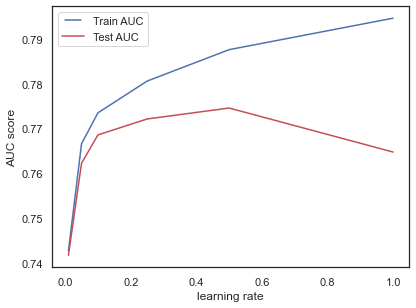

In [887]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
    print(eta)
    model = GradientBoostingClassifier(learning_rate=eta)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

10 done
50 done
100 done
125 done
150 done
175 done
200 done
250 done


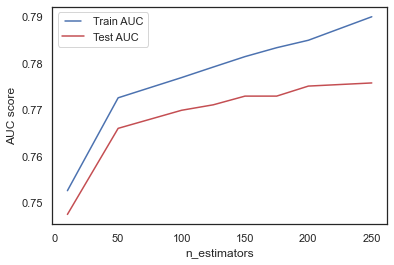

In [936]:
n_estimators = [10, 50, 100, 125, 150, 175, 200, 250]
train_results = []
test_results = []
for estimator in n_estimators:
    model = GradientBoostingClassifier(learning_rate=0.1,n_estimators=estimator,max_depth=4,max_features=5)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    print(f"{estimator} done")
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

1
2
3
4
8
16


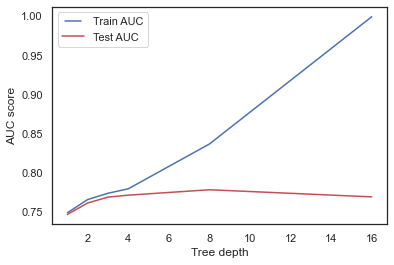

In [934]:
max_depths = [1,2,3,4,5,6]
train_results = []
test_results = []
for max_depth in max_depths:
    print(max_depth)
    model = GradientBoostingClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

0.01
0.05
0.1
0.2
0.25
0.5
0.75
1.0


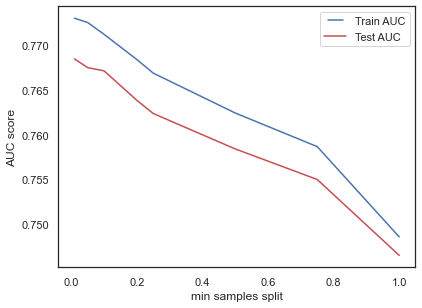

In [893]:
min_samples_splits = [0.01,0.05,0.1,0.2,0.25,0.5,0.75,1.0]
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    print(min_samples_split)
    model = GradientBoostingClassifier(min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14


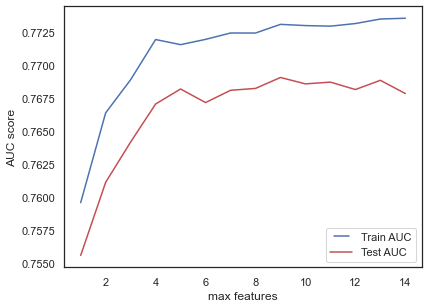

In [894]:
max_features = list(range(1,len(features)))
train_results = []
test_results = []
for max_feature in max_features:
    print(max_feature)
    model = GradientBoostingClassifier(max_features=max_feature)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

In [899]:
gb = GradientBoostingClassifier()
gb.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [975]:
objects = [tfid_vectorizer,q1weights,scaler,model,clf,nlp,tfidf_tokens,features,doc_embeddings1,sbert_model]
object_names = ['tfid_vectorizer','q1weights','scaler','model','clf','nlp','tfidf_tokens','features','doc_embeddings1','sbert_model']
for ix, i in enumerate(objects):
    pickle.dump(i, open( "final/"+str(object_names[ix])+".p", "wb" ))

# 4. Comparing Additional Models

In [696]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate', 'q1len',
       'q2len', 'q1_n_words', 'q2_n_words', 'word_share', 'flesch_diff',
       'dalechall_diff', 'q_n_words_diff', 'qlen_diff', 'q1_cleaned',
       'q2_cleaned', 'tfidf_cosine_sim', 'entities1', 'entity_types1',
       'entities2', 'entity_types2', 'diff_num_entities', 'common_entities',
       'common_entity_types', 'tfidf_cosine_sim_', 'tfidf_word_match',
       'bert_cosine_sim_'],
      dtype='object')

In [1050]:
features = ['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share',
            'flesch_diff', 'dalechall_diff', 'q_n_words_diff', 'qlen_diff',
            'diff_num_entities', 'common_entities', 'common_entity_types', 
            'tfidf_cosine_sim_', 'tfidf_word_match','bert_cosine_sim_']
#features=['word_share', 'tfidf_word_match', 'diff_num_entities']

In [1051]:
scaler = MinMaxScaler().fit(df[features])

X = scaler.transform(df[features])
y = df['is_duplicate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70000, 15), (30000, 15), (70000,), (30000,))

In [1056]:
# Instantiate the classfiers and make a list
# classifiers=[LogisticRegression(random_state=42)]
classifiers = [LogisticRegression(random_state=42),  
#               KNeighborsClassifier(), 
               RandomForestClassifier(random_state=42),
#                GradientBoostingClassifier(learning_rate=0.1,n_estimators=150,max_depth=4,max_features=5),
                GradientBoostingClassifier(random_state=42),
                xgb.XGBClassifier(random_state=1,learning_rate=0.01),
                GradientBoostingClassifier(learning_rate=0.1,n_estimators=256,max_depth=4,max_features=5)]
classifier_names=['Logistic Regresion','Random Forest','Gradient Boosting','XGBoost','Gradient Boosting (Fine-Tuned)']

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc',
                                     'test accuracy','test recall','test precision',
                                     'train accuracy','train recall','train precision'])

# Train the models and record the results
for ix,clf in enumerate(classifiers):
    print('1')
    model = clf.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    y_pred=clf.predict(X_test)
    y_pred_train=clf.predict(X_train)
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc_ = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':classifier_names[ix],
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc_,
                                        'test accuracy':metrics.accuracy_score(y_test, y_pred),
                                        'train accuracy':metrics.accuracy_score(y_train, y_pred_train),
                                        'test recall':metrics.recall_score(y_test, y_pred),
                                        'train recall':metrics.recall_score(y_train, y_pred_train),
                                        'test precision':metrics.precision_score(y_test, y_pred),
                                        'train precision':metrics.precision_score(y_train, y_pred_train)
                                       }, ignore_index=True)    

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

1
1
1
1
[12:14:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1


In [1060]:
result_table[['test accuracy', 'train accuracy', 'test recall', 'train recall', 'test precision', 'train precision','auc']].nlargest(5,'auc')

,test accuracy,train accuracy,test recall,train recall,test precision,train precision,auc
classifiers,,,,,,,
Random Forest,0.775467,1.000000,0.829027,1.000000,0.749925,1.000000,0.856836
Gradient Boosting (Fine-Tuned),0.776267,0.790014,0.844902,0.858406,0.743990,0.754679,0.856104
Gradient Boosting,0.768867,0.773400,0.844836,0.848390,0.734481,0.737286,0.848031
XGBoost,0.765633,0.772329,0.848157,0.855287,0.729074,0.733124,0.845291
Logistic Regresion,0.730067,0.730971,0.792096,0.794305,0.705914,0.704475,0.804550


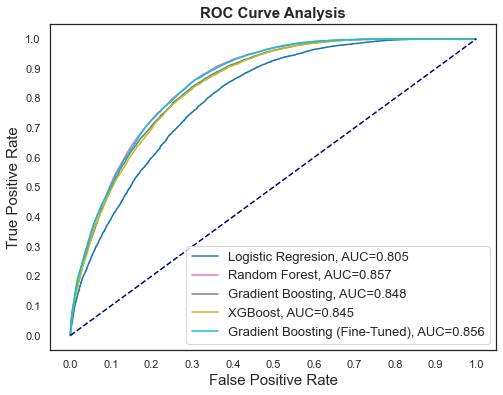

In [1058]:
fig = plt.figure(figsize=(8,6))
colors = ['#1f77b4', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

for ix,i in enumerate(result_table.index):
    plt.plot(result_table.iloc[ix]['fpr'], 
             result_table.iloc[ix]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.iloc[ix]['auc']),
            color=colors[ix])
    
plt.plot([0,1], [0,1], color='navy', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

No handles with labels found to put in legend.


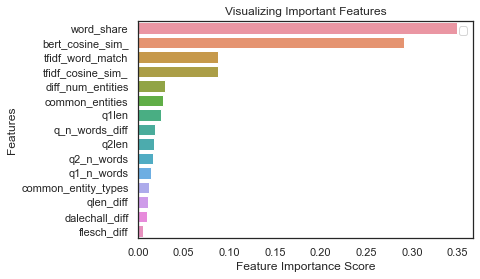

In [1061]:
feature_imp = pd.Series(clf.feature_importances_,index = features).sort_values(ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Demo

In [631]:
print(user_input_question)
print('Here are some similar questions:')
demo_df[['question1','word_share','tfidf_word_match','model_score','model_pred']].nlargest(5,'model_score')

What can we do about climate change?
Here are some similar questions:


,question1,word_share,tfidf_word_match,model_score,model_pred
4711,What small part can individuals do to help combat Climate Change?,0.555556,0.628531,0.724458,1
20290,Can climate change be reversed?,0.500000,0.786092,0.710267,1
40083,What important steps can we take as individuals to combat climate change?,0.526316,0.624907,0.699313,1
75656,What can change my life?,0.500000,0.479139,0.678626,1
4104,What are the most effective things ordinary people can do to fight climate change?,0.476190,0.596919,0.675614,1


In [640]:
print(user_input_question)
print('Here are some similar questions:')
demo_df[['question1','model_score']].nlargest(5,'model_score')

Is Brexit going to benefit Britain?
Here are some similar questions:


,question1,model_score
48843,whats your opinion about Britain leaving the EU and brexit,0.389822
80118,What is the impact of Brexit on Argentina?,0.354218
76040,What is Jake William’s opinion on Brexit ?,0.352935
27100,Is Brexit really happening?,0.345500
32029,Is Brexit really happening?,0.345500


# Identifying duplicate questions
# Summary

## 0. The data

In [1034]:
array=[83486,120258,224815,381962]
df[['question1','question2','is_duplicate']].loc[df['id'].isin(array)]

,question1,question2,is_duplicate
49999,What is the most bizarre interview question you have ever asked?,Which is the strangest question you have ever been asked in an interview?,1
52266,Are Venmo payouts reversible?,Can I use Venmo without a Social Security Number?,0
52886,What is the importance of statistics in science?,"In psychology, what is the importance of statistics?",0
66625,What is the most common mental illness?,How common is mental illness?,0


## 1. Initial Variables

In [1035]:
df[['question1','question2','q1len','q2len','q1_n_words','q2_n_words','qlen_diff','q_n_words_diff','word_share', 'dalechall_diff']].loc[df['id'].isin(array)]

,question1,question2,q1len,q2len,q1_n_words,q2_n_words,qlen_diff,q_n_words_diff,word_share,dalechall_diff
49999,What is the most bizarre interview question you have ever asked?,Which is the strangest question you have ever been asked in an interview?,64,73,11,13,9,2,0.666667,1.557094
52266,Are Venmo payouts reversible?,Can I use Venmo without a Social Security Number?,29,49,4,9,20,5,0.153846,6.331167
52886,What is the importance of statistics in science?,"In psychology, what is the importance of statistics?",48,52,8,8,4,0,0.875000,0.000000
66625,What is the most common mental illness?,How common is mental illness?,39,29,7,5,10,2,0.666667,2.607657


## 2. Pre-processing for NLP

* Tokenization & Lemmatization
* Removal of Stopwords

In [1036]:
df[['question1','q1_cleaned','question2','q2_cleaned']].loc[df['id'].isin(array)]

,question1,q1_cleaned,question2,q2_cleaned
49999,What is the most bizarre interview question you have ever asked?,bizarre interview question ask,Which is the strangest question you have ever been asked in an interview?,strange question ask interview
52266,Are Venmo payouts reversible?,venmo payout reversible,Can I use Venmo without a Social Security Number?,use venmo social security number
52886,What is the importance of statistics in science?,importance statistic science,"In psychology, what is the importance of statistics?",psychology importance statistic
66625,What is the most common mental illness?,common mental illness,How common is mental illness?,common mental illness


## 3. Document Similarities

* TF-IDF Vectorization
* Cosine Similarity
* Word Share Score

In [1037]:
df[['q1_cleaned','q2_cleaned','tfidf_cosine_sim_', 'tfidf_word_match',]].loc[df['id'].isin(array)]

,q1_cleaned,q2_cleaned,tfidf_cosine_sim_,tfidf_word_match
49999,bizarre interview question ask,strange question ask interview,0.755210,0.821973
52266,venmo payout reversible,use venmo social security number,0.000000,0.000000
52886,importance statistic science,psychology importance statistic,0.730157,0.700435
66625,common mental illness,common mental illness,1.000000,1.000000


## 4. Named Entity Recognition

In [1038]:
df[['q1_cleaned','entities1','entity_types1','q2_cleaned', 'entities2','entity_types2','diff_num_entities','common_entities','common_entity_types']].loc[df['id'].isin(array)]

,q1_cleaned,entities1,entity_types1,q2_cleaned,entities2,entity_types2,diff_num_entities,common_entities,common_entity_types
49999,bizarre interview question ask,[],[],strange question ask interview,[],[],0,-1.000000,-1.000000
52266,venmo payout reversible,[Venmo],[ORG],use venmo social security number,"[Venmo, Social Security Number]","[ORG, ORG]",1,0.666667,0.666667
52886,importance statistic science,[],[],psychology importance statistic,[],[],0,-1.000000,-1.000000
66625,common mental illness,[],[],common mental illness,[],[],0,-1.000000,-1.000000


## 5. BERT Cosine Similarity

In [1039]:
df[['question1','question2','bert_cosine_sim_']].loc[df['id'].isin(array)]

,question1,question2,bert_cosine_sim_
49999,What is the most bizarre interview question you have ever asked?,Which is the strangest question you have ever been asked in an interview?,0.927922
52266,Are Venmo payouts reversible?,Can I use Venmo without a Social Security Number?,0.529786
52886,What is the importance of statistics in science?,"In psychology, what is the importance of statistics?",0.856371
66625,What is the most common mental illness?,How common is mental illness?,0.887499


## 6. Model Prediction

In [1041]:
df[['question1','question2','model_score','model_pred','is_duplicate']].loc[df['id'].isin(array)]

,question1,question2,model_score,model_pred,is_duplicate
49999,What is the most bizarre interview question you have ever asked?,Which is the strangest question you have ever been asked in an interview?,0.737990,1,1
52266,Are Venmo payouts reversible?,Can I use Venmo without a Social Security Number?,0.080269,0,0
52886,What is the importance of statistics in science?,"In psychology, what is the importance of statistics?",0.643265,1,0
66625,What is the most common mental illness?,How common is mental illness?,0.723545,1,0
